# FIDE & Google Efficient Chess AI Challenge

Welcome! This notebook will familiarize you with using competition's environment, creating an agent, and submitting your first chess bot!

In [1]:
# first let's make sure you have internet enabled
import requests
requests.get('http://www.google.com',timeout=10).ok

True

#### If you don't have internet access (it doesn't say "True" above)
1. make sure your account is Phone Verified in [account settings](https://www.kaggle.com/settings)
2. make sure internet is turned on in Settings -> Turn on internet

In [2]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [3]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



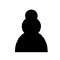
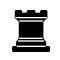
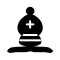
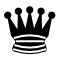
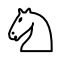
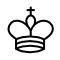
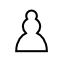
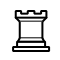
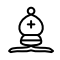
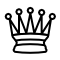
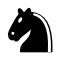
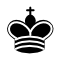

In [4]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

### Creating your first agent
Now let's create your first agent! The environment has the [Chessnut](https://github.com/cgearhart/Chessnut) pip package installed and we'll use that to parse the board state and generate moves.

In [5]:
%%writefile main.py
from Chessnut import Game
import random
from collections import namedtuple,defaultdict

# Define the transition for learning
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ChessAgent:
    def __init__(self, learning_rate=0.01, discount_factor=0.9, epsilon_greedy=0.9, epsilon_min=0.1, epsilon_decay=0.95):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon_greedy
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = defaultdict(lambda: defaultdict(float))  # Q-table initialized with zero

    def choose_action(self, game):
        """
        Select an action based on epsilon-greedy strategy.
        Includes prioritizing checkmate, capturing pieces, and queen promotion.
        """
        moves = list(game.get_moves())
        if not moves:  # No moves available
            print("No moves available.")
            return None
    
        # Debugging: print available moves
        print(f"Available moves: {moves}")
    
        # 1. Check for checkmate move
        for move in moves:
            g = Game(obs.board)
            g.apply_move(move)
            if g.status == Game.CHECKMATE:
                print(f"Checkmate found: {move}")
                return move  # Prioritize checkmate
    
        # 2. Check for captures
        for move in moves:
            g = Game(obs.board)
            g.apply_move(move)
            # Check if the move captures a piece
            if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
                print(f"Capture move found: {move}")
                return move  # Prioritize captures
    
        # 3. Check for queen promotions
        for move in moves:
            if "q" in move.lower():
                print(f"Queen promotion move found: {move}")
                return move  # Prioritize queen promotion
    
        # 4. Epsilon-greedy strategy (choose random move or best known move)
        if random.uniform(0, 1) < self.epsilon:
            # Explore: choose a random move
            print("Exploring (random move).")
            return random.choice(moves)
        else:
            # Exploit: choose the best known move
            state = game.get_fen()
            q_values = [(move, self.q_table[state][move]) for move in moves]
            best_move = max(q_values, key=lambda x: x[1])[0]
            print(f"Exploiting (best known move): {best_move}")
            return best_move


    def learn(self, transition):
        """
        Update Q-values based on the transition.
        """
        state, action, reward, next_state, done = transition
        q_val = self.q_table[state][action]
        if done:
            q_target = reward
        else:
            next_q_vals = [self.q_table[next_state][a] for a in self.q_table[next_state]]
            q_target = reward + self.gamma * max(next_q_vals, default=0)
        self.q_table[state][action] += self.lr * (q_target - q_val)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
def play_chess_interactive(obs):
    agent = ChessAgent()
    """
    Returns the agent's move given the current game state. Assumes the opponent's move has already been made.
    """
    game = Game(obs.board)  # Initialize a new chess game
        # Agent's turn
    action = agent.choose_action(game)
    if action is None:
        return None
    game.apply_move(action)  # Apply the agent's move
    return action  # Return only the agent's move



Writing main.py


In [6]:
%%writefile main.py
def chess_bot(obs):
    """
    Simple chess bot that prioritizes checkmates, then captures, queen promotions, then randomly moves.

    Args:
        obs: An object with a 'board' attribute representing the current board state as a FEN string.

    Returns:
        A string representing the chosen move in UCI notation (e.g., "e2e4")
    """
    # 0. Parse the current board state and generate legal moves using Chessnut library
    game = Game(obs.board)
    moves = list(game.get_moves())

    # 1. Check a subset of moves for checkmate
    for move in moves[:10]:
        g = Game(obs.board)
        g.apply_move(move)
        if g.status == Game.CHECKMATE:
            return move

    # 2. Check for captures
    for move in moves:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return move

    # 3. Check for queen promotions
    for move in moves:
        if "q" in move.lower():
            return move

    # 4. Random move if no checkmates or captures
    return random.choice(moves)

Overwriting main.py


### Testing your agent

Now let's see how your agent does againt the random agent!

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/kaggle_environments/agent.py", line 169, in act
    action = self.agent(*args)
  File "/opt/conda/lib/python3.10/site-packages/kaggle_environments/agent.py", line 140, in callable_agent
    agent(*args) \
  File "main.py", line 12, in chess_bot
    game = Game(obs.board)
NameError: name 'Game' is not defined
Error: ['Traceback (most recent call last):\n', '  File "/opt/conda/lib/python3.10/site-packages/kaggle_environments/agent.py", line 169, in act\n    action = self.agent(*args)\n', '  File "/opt/conda/lib/python3.10/site-packages/kaggle_environments/agent.py", line 140, in callable_agent\n    agent(*args) \\\n', '  File "main.py", line 12, in chess_bot\n    game = Game(obs.board)\n', "NameError: name 'Game' is not defined\n"]
Agent exit status/reward/time left: 
	 ERROR / None / 10
	 DONE / 0 / 10





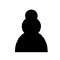
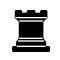
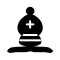
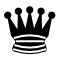
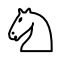
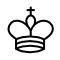
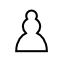
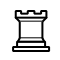
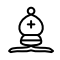
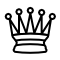
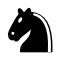
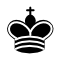

In [7]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=1000, height=1000) 

# To Submit:
1. Download (or save) main.py
2. Go to the [submissions page](https://www.kaggle.com/competitions/fide-google-efficiency-chess-ai-challenge/submissions) and click "Submit Agent"
3. Upload main.py
4. Press Submit!

Now doubt you are already thinking of ways this bot could be improved! Go ahead and fork this notebook and get started! ♟️

# Submitting Multiple files 
### (or compressing your main.py)

Set up your directory structure like this:
```
kaggle_submissions/
  main.py
  <other files as desired>
```

You can run `tar -czf submission.tar.gz -C kaggle_submissions .` and upload `submission.tar.gz`